In [1]:
# Import our dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

### Utility functions to reduce duplication of code 

In [2]:
# Function to proceduralize categorical feature reduction
def reduce_categorical(df, category_map):
    for cat in category_map:
        cat_types = df[cat].value_counts()
        cat_thld  = cat_types[category_map[cat]]
        cat_other = cat_types[cat_types<cat_thld].index.tolist()
        cat_mask  = df[cat].isin(cat_other)
        
        df.loc[cat_mask, cat] = 'Other'

In [3]:
def show_features(df):
    # Generate our list of categorical features
    type_mask = df.dtypes=='object'
    cat = (df.dtypes[type_mask]).index.tolist()

    print(f'Number of columns: {len(df.columns)}')
    print(f'Number of categorical columns: {len(cat)}')
    print(f'\nNumber of features: {df[cat].nunique().sum()} \n')

    print(df[cat].nunique())
    
    return cat

In [4]:
# Function to proceduralize one-hot encoding of categorical features
def do_encode(df):
    # Get list of categorical features
    cat = df.dtypes[df.dtypes=='object'].index.tolist()
    
    # Create a OneHotEncoder instance
    enc = OneHotEncoder(drop='if_binary', sparse=False)

    # Fit and transform the OneHotEncoder using the categorical variable list
    encode_df = pd.DataFrame(enc.fit_transform(df[cat]), index=df.index)

    # Add the encoded variable names to the dataframe
    encode_df.columns = enc.get_feature_names_out()
    
    # Merge one-hot encoded features and drop the originals
    encode_df = pd.concat([df, encode_df], axis=1)
    encode_df.drop(cat, axis=1, inplace=True)
    
    return encode_df

In [5]:
# Function to proceduralize train, test, split
def do_split(df, target):
    # Split our preprocessed data into our features and target arrays
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
    
    # Create a StandardScaler instances
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled  = X_scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [40]:
# Function to proceduralize creation and fit of a model
def do_model(name, X, y, layers=[50, 30], epochs=20, activation='relu', activation_last='sigmoid', 
             optimizer='adam', summary=False, verbose=False, save_wts=None):
    
    #Setup model layers
    nn = tf.keras.models.Sequential()
    
    # First hidden layer
    input_dim = X.shape[1]
    nn.add(tf.keras.layers.Dense(units=layers[0], activation=activation, input_dim=input_dim))
    
    # Additional layers
    for layer in layers[1:]:
        nn.add(tf.keras.layers.Dense(units=layer, activation=activation))
        
    # Output layer
    nn.add(tf.keras.layers.Dense(units=1, activation=activation_last))

    # Check the structure of the model
    if summary:
        nn.summary()
        
    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    # Check if weigths to be saved
    verbose=(1 if verbose else 0)
    
    if save_wts is not None:
        wts_file = f'{save_wts}_{name}'+'_{epoch:02d}.hdf5'
        print('Weights', wts_file)
        
        callbacks = [ModelCheckpoint(filepath=wts_file, verbose=verbose, save_weights_only=True, period=5)]
    else:
        callbacks = None
    
    # Train the model
    fit_model = nn.fit(X_train_scaled, y_train, epochs=epochs, verbose=verbose, callbacks=callbacks)
    
    # Return the model
    return nn, pd.DataFrame(fit_model.history).rename(columns={'loss':name+'_loss', 'accuracy':name+'_accuracy'})

In [7]:
# Function to proceduralize plot of history weights for comparison
def do_plot(results, loss_title=None, accuracy_title=None, slice_from=0):
    # Create data frames for loss and accuracy from the results list
    loss = pd.concat([results[key]['hist'].iloc[slice_from:, 0] for key in results], axis=1)
    accuracy = pd.concat([results[key]['hist'].iloc[slice_from:, 1] for key in results], axis=1)
    
    # Create figure and 2 sub-plots
    fig  = plt.figure(figsize=(12, 4))
    loss_axes = fig.add_subplot(121)
    accuracy_axes = fig.add_subplot(122)
    
    # Set plots labels and titles
    loss_label = loss_title if loss_title else 'Loss Comparison'
    accuracy_label = accuracy_title if accuracy_title else 'Accuracy Comparison'
    loss_axes.set_title(loss_label); loss_axes.set_xlabel('Epochs'); loss_axes.set_ylabel('Loss')
    accuracy_axes.set_title(accuracy_label); accuracy_axes.set_xlabel('Epochs'); accuracy_axes.set_ylabel('Accuracy')
    
    # Plot the history results
    loss.plot(ax=loss_axes)
    accuracy.plot(ax=accuracy_axes)

### Read in the data set ...

In [8]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [9]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(['EIN', 'NAME'], axis=1, inplace=True)
application_df_copy = application_df.copy()   # Save for comparison to feature reduced model

### Feature Reduction : Try feature reduction to improve accuracy of NN model

In [10]:
# Determine the number of unique values in each column.
pd.DataFrame([application_df.nunique(), application_df.dtypes]).T

,0,1
APPLICATION_TYPE,17,object
AFFILIATION,6,object
CLASSIFICATION,71,object
USE_CASE,5,object
ORGANIZATION,4,object
STATUS,2,int64
INCOME_AMT,9,object
SPECIAL_CONSIDERATIONS,2,object
ASK_AMT,8747,int64
IS_SUCCESSFUL,2,int64


In [11]:
# Check value counts for features with only 2 unique values
application_df['STATUS'].value_counts(), application_df['SPECIAL_CONSIDERATIONS'].value_counts()

(1    34294
 0        5
 Name: STATUS, dtype: int64,
 N    34272
 Y       27
 Name: SPECIAL_CONSIDERATIONS, dtype: int64)

In [12]:
# Dropping 'STATUS' and SPECIAL_CONSIDERATIONS'columns as they are basically constant
application_df.drop(['STATUS', 'SPECIAL_CONSIDERATIONS'], axis=1, inplace=True)

In [13]:
# Get columns and feature counts for the data set
application_cat = show_features(application_df)

Number of columns: 8
Number of categorical columns: 6

Number of features: 112 

APPLICATION_TYPE    17
AFFILIATION          6
CLASSIFICATION      71
USE_CASE             5
ORGANIZATION         4
INCOME_AMT           9
dtype: int64


In [14]:
# Review value counts for remaining categorical columns
for cat in application_cat:
    counts = application_df[cat].value_counts()
    print('Column: ', cat, '  Count: ', len(counts))
    print(counts.iloc[:10], '\n')

Column:  APPLICATION_TYPE   Count:  17
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
Name: APPLICATION_TYPE, dtype: int64 

Column:  AFFILIATION   Count:  6
Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64 

Column:  CLASSIFICATION   Count:  71
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
Name: CLASSIFICATION, dtype: int64 

Column:  USE_CASE   Count:  5
Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: USE_CASE, dtype: int64 

Column:  ORGANIZATION   Count:  4
Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: int64 

Column:  INC

In [15]:
# After reviewing categorical counts and experimentation, 
# decided to limit each categorical feature to no more than 4 categories. 
# Reduction is base on value of the 3rd or 4th largest category
cat_map = {'APPLICATION_TYPE':'T19', 'AFFILIATION':'CompanySponsored', 'CLASSIFICATION':'C2100',
           'USE_CASE':'ProductDev', 'ORGANIZATION':'Association', 'INCOME_AMT':'100000-499999'}

reduce_categorical(application_df, cat_map)

In [16]:
# Get columns and feature counts for the feature reduced data set
show_features(application_df)

Number of columns: 8
Number of categorical columns: 6

Number of features: 25 

APPLICATION_TYPE    6
AFFILIATION         3
CLASSIFICATION      6
USE_CASE            3
ORGANIZATION        3
INCOME_AMT          4
dtype: int64


['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [17]:
# One-Hot encode the categorical features
encode_df = do_encode(application_df)

In [18]:
# Review correlation matrix for potential further feature reduction opportunities
corr = encode_df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_Other,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_100000-499999,INCOME_AMT_25000-99999,INCOME_AMT_Other
ASK_AMT,1.00,-0.01,-0.00,-0.01,0.01,-0.01,-0.00,-0.01,-0.02,0.02,0.03,0.00,-0.00,0.01,-0.01,-0.01,-0.00,0.09,-0.02,-0.01,-0.02,0.03,0.01,-0.05,-0.01,-0.01,0.10
IS_SUCCESSFUL,-0.01,1.00,0.05,-0.12,-0.00,-0.10,0.09,0.08,-0.37,0.37,0.01,0.06,-0.06,-0.00,-0.15,-0.02,0.11,-0.04,0.02,-0.01,-0.18,0.06,0.16,-0.05,0.03,0.03,0.02
APPLICATION_TYPE_Other,-0.00,0.05,1.00,-0.05,-0.51,-0.06,-0.05,-0.05,0.08,-0.08,-0.00,0.26,-0.11,-0.11,-0.06,-0.06,-0.07,-0.01,-0.26,0.28,0.22,0.11,-0.25,0.06,-0.05,-0.04,0.01
APPLICATION_TYPE_T19,-0.01,-0.12,-0.05,1.00,-0.35,-0.04,-0.03,-0.03,0.12,-0.12,-0.00,0.18,-0.07,-0.08,-0.04,-0.04,-0.05,-0.01,-0.20,0.21,0.20,-0.02,-0.19,0.08,-0.04,-0.05,-0.04
APPLICATION_TYPE_T3,0.01,-0.00,-0.51,-0.35,1.00,-0.42,-0.36,-0.37,-0.20,0.20,0.01,-0.11,0.21,0.07,0.12,-0.46,0.12,0.01,0.80,-0.84,-0.40,-0.05,0.41,-0.09,0.07,0.04,0.03
APPLICATION_TYPE_T4,-0.01,-0.10,-0.06,-0.04,-0.42,1.00,-0.04,-0.04,0.09,-0.09,-0.01,-0.09,-0.09,-0.08,-0.05,0.53,-0.03,-0.02,-0.38,0.40,0.19,-0.01,-0.18,0.06,-0.04,-0.02,-0.03
APPLICATION_TYPE_T5,-0.00,0.09,-0.05,-0.03,-0.36,-0.04,1.00,-0.04,0.14,-0.13,-0.01,-0.09,-0.08,-0.08,-0.05,0.55,-0.05,0.00,-0.40,0.41,0.18,0.01,-0.18,0.01,-0.01,-0.00,-0.00
APPLICATION_TYPE_T6,-0.01,0.08,-0.05,-0.03,-0.37,-0.04,-0.04,1.00,-0.02,0.02,0.00,-0.09,-0.07,0.24,-0.05,0.00,-0.05,0.01,-0.41,0.42,0.00,-0.02,0.00,-0.02,0.00,0.03,-0.00
AFFILIATION_CompanySponsored,-0.02,-0.37,0.08,0.12,-0.20,0.09,0.14,-0.02,1.00,-0.99,-0.05,-0.16,0.05,0.03,0.19,0.15,-0.11,0.07,-0.16,0.15,0.48,-0.11,-0.45,0.28,-0.14,-0.12,-0.17
AFFILIATION_Independent,0.02,0.37,-0.08,-0.12,0.20,-0.09,-0.13,0.02,-0.99,1.00,-0.06,0.15,-0.05,-0.03,-0.18,-0.15,0.11,-0.07,0.16,-0.15,-0.48,0.10,0.45,-0.27,0.14,0.12,0.16


In [19]:
# Split data into training and test sets
X_train_scaled, X_test_scaled, y_train, y_test = do_split(encode_df, 'IS_SUCCESSFUL')

In [20]:
# Train new model with feature reduction of data set
new_model, new_hist = do_model('new', X_train_scaled, y_train, epochs=100, verbose=False)

In [21]:
# Evaluate the model using the test data
model_loss, model_accuracy = new_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5577 - accuracy: 0.7264 - 355ms/epoch - 1ms/step
Loss: 0.557658314704895, Accuracy: 0.7264139652252197


#### Compare with original ASC model

In [22]:
# Need X_test and y_test for the original model to evaluate with saved model
# Reduction is base on value of the 3rd or 4th largest category
cat_map = {'APPLICATION_TYPE':'T10', 'CLASSIFICATION':'C2100'}
reduce_categorical(application_df_copy, cat_map)
encode_df_orig = do_encode(application_df_copy)
_, X_test_orig, _, y_test_orig = do_split(encode_df_orig, 'IS_SUCCESSFUL')

In [23]:
# Load and run the saved model
nn_load = tf.keras.models.load_model('ASC_model.hd5')

model_loss, model_accuracy = nn_load.evaluate(X_test_orig, y_test_orig, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5566 - accuracy: 0.7270 - 328ms/epoch - 1ms/step
Loss: 0.5566019415855408, Accuracy: 0.7269970774650574


### Define tests with multiple configurations to find optimal set of parameters

In [24]:
#Layers
layers = {'2-layers':[50, 30], '3-layers':[50, 30, 10], '4-layers':[50, 30, 10, 10]}

# Activtion functions
activations = {'relu':'relu', 'tanh':'tanh', 'elu':'elu', 'selu':'selu'}
        
# Epochs
# epochs = {'50_epochs':50, '100_epochs':100, '200_epochs':200, '300_epochs':300}
epochs = {'20_epochs':20, '50_epochs':50, '100_epochs':100}

##### Run test with different epoch configurations

Running test:  20_epochs
Running test:  50_epochs
Running test:  100_epochs


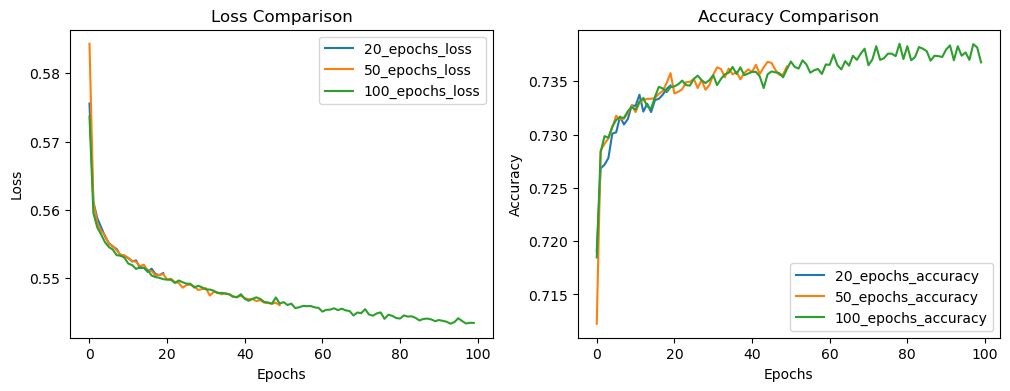

In [25]:
# Run test with different epoch configurations
tests = epochs
test_results = {}
for test in tests:
    print("Running test: ", test)
    model, hist = do_model(test, X_train_scaled, y_train, layers=layers['4-layers'], epochs=tests[test], verbose=False)
    test_results[test] = {'model':model, 'hist':hist}
    
# Plot results for comparison
do_plot(test_results)
epoch_results = test_results

In [26]:
# Evaluate the models using the test data
for test in test_results:
    nn = test_results[test]['model']
    model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test: {test}, Loss: {model_loss}, Accuracy: {model_accuracy}")

Test: 20_epochs, Loss: 0.5582823157310486, Accuracy: 0.7244315147399902
Test: 50_epochs, Loss: 0.5598892569541931, Accuracy: 0.7257142663002014
Test: 100_epochs, Loss: 0.5586583018302917, Accuracy: 0.7253644466400146


In [27]:
# Use 100 epochs for subsequent processing on evaluation accuracy results
use_epochs = 100

##### Run test with different layer configurations

Running test:  2-layers
Running test:  3-layers
Running test:  4-layers


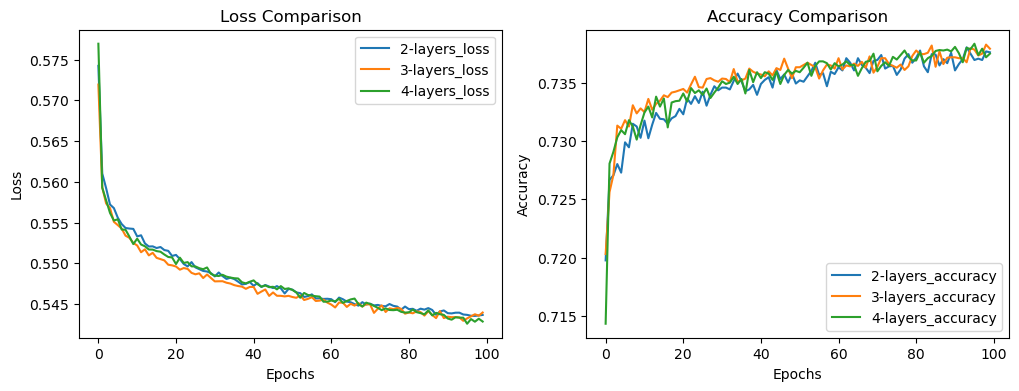

In [28]:
# Run test with different layer configurations
tests = layers
test_results = {}
for test in tests:
    print("Running test: ", test)
    model, hist = do_model(test, X_train_scaled, y_train, layers=tests[test], epochs=use_epochs, verbose=False)
    test_results[test] = {'model':model, 'hist':hist}
    
# Plot results for comparison
do_plot(test_results)
layer_results = test_results

In [29]:
# Evaluate the models using the test data
for test in test_results:
    nn = test_results[test]['model']
    model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test: {test}, Loss: {model_loss}, Accuracy: {model_accuracy}")

Test: 2-layers, Loss: 0.5572758316993713, Accuracy: 0.7282798886299133
Test: 3-layers, Loss: 0.5580731630325317, Accuracy: 0.7241982221603394
Test: 4-layers, Loss: 0.5592744946479797, Accuracy: 0.7262973785400391


In [30]:
# Use 2 layers for subsequent processing based on evaluation accuracy results
use_layers = layers['2-layers']

##### Run test with different activation functions

Running test:  relu
Running test:  tanh
Running test:  elu
Running test:  selu


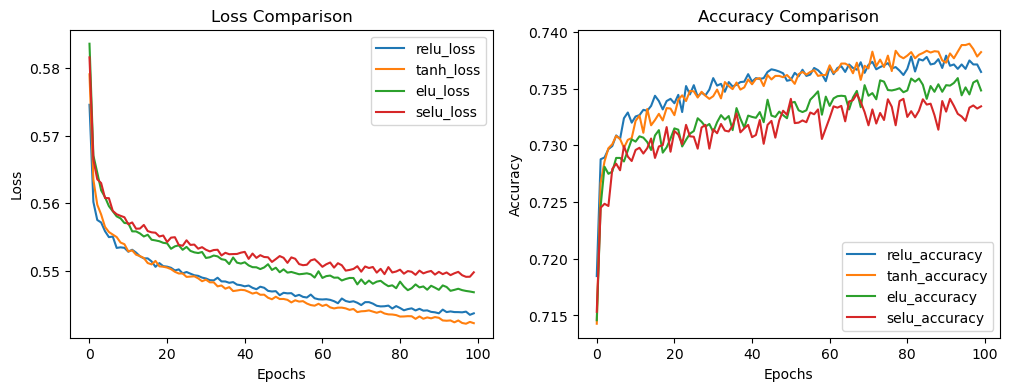

In [31]:
# Run test with different activation configurations
tests = activations
test_results = {}
for test in tests:
    print("Running test: ", test)
    model, hist = do_model(test, X_train_scaled, y_train, layers=use_layers, activation=tests[test], epochs=use_epochs, verbose=False)
    test_results[test] = {'model':model, 'hist':hist}
    
# Plot results for comparison
do_plot(test_results)
actfn_results = test_results

In [32]:
# Evaluate the models using the test data
for test in test_results:
    nn = test_results[test]['model']
    model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test: {test}, Loss: {model_loss}, Accuracy: {model_accuracy}")

Test: relu, Loss: 0.5579138398170471, Accuracy: 0.7282798886299133
Test: tanh, Loss: 0.5579419136047363, Accuracy: 0.7229154706001282
Test: elu, Loss: 0.5561389327049255, Accuracy: 0.7252478003501892
Test: selu, Loss: 0.5554481148719788, Accuracy: 0.7237317562103271


In [33]:
# Use xx activation for subsequent processing based on evaluation accuracy results
use_activation = 'relu'

#### Run model with final parameters, save weights and model to files 

In [34]:
# Establish checkpoint file path
os.makedirs("Checkpoints/", exist_ok=True)
save_wts = 'Checkpoints/weights'

Weights Checkpoints/weights_final_{epoch:02d}.hdf5


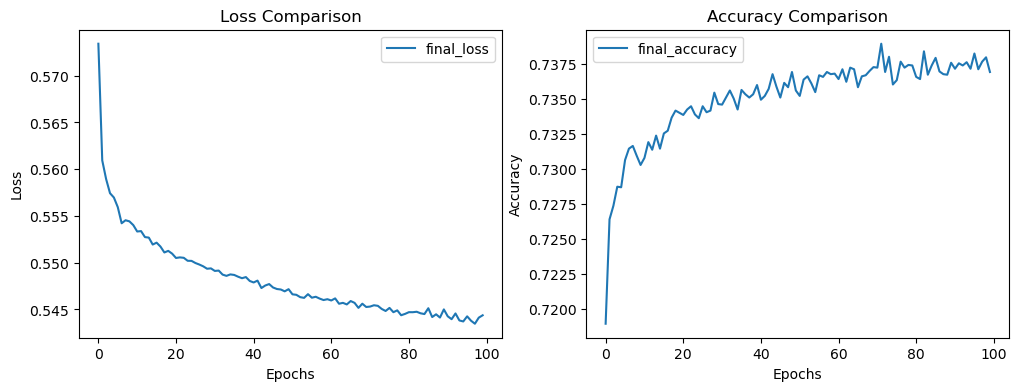

In [41]:
# Run final model with parameters from above results
test = 'final'
model, hist = do_model(test, X_train_scaled, y_train, layers=use_layers, activation=use_activation, 
                       epochs=use_epochs, verbose=False, save_wts=save_wts)
do_plot({test:{'hist':hist}})

In [42]:
# Evaluate model on test data
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test: {test}, Loss: {model_loss}, Accuracy: {model_accuracy}")

Test: final, Loss: 0.5580029487609863, Accuracy: 0.7238484025001526


In [44]:
# Save the model
save_file = 'Final_ASC_model.hd5'
model.save(save_file)

INFO:tensorflow:Assets written to: Final_ASC_model.hd5\assets


INFO:tensorflow:Assets written to: Final_ASC_model.hd5\assets


In [45]:
# Load and run the saved model
nn_load = tf.keras.models.load_model(save_file)

model_loss, model_accuracy = nn_load.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5580 - accuracy: 0.7238 - 283ms/epoch - 1ms/step
Loss: 0.5580029487609863, Accuracy: 0.7238484025001526
